# Определение возраста покупателей


Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Порядок выполнения проекта

1. Провести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению.
3. Обучить нейронную сеть и рассчитайте её качество _(на тренажере с GPU)_


# Исследовательский анализ данных

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [6]:
print(labels.shape)
features, target = next(train_gen_flow)

print(features.shape)

(7591, 2)
(32, 224, 224, 3)


Всего 7591 картинка. Это хороший размер датасета для обучения нейросети.

32-мерный тензор, с 32 фотографиями размером 224 на 224 пикселя и 3 канала с цветом.

In [7]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Метки с возрастом хранятся в столбце `real_age`. 

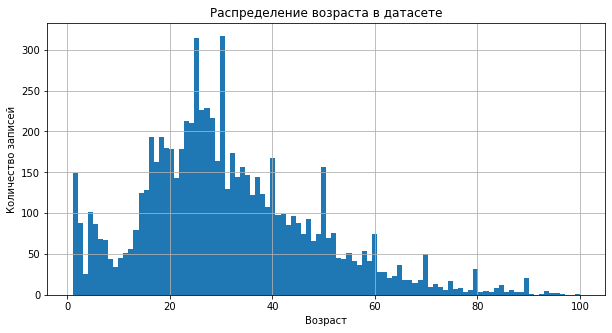

In [8]:
labels['real_age'].hist(bins=100, figsize=(10,5));
plt.xlabel('Возраст')
plt.ylabel('Количество записей')
plt.title('Распределение возраста в датасете');

По распеределению возрастов людей на фото в датасете видно, что больше всего фото - людей молодого и среднего возраста - с 16 до 40 лет. Так как выборка таких возрастов шире, то и предсказывать возраст в данной области нейросеть будет лучше. 

Так же достаточно много фото детей с самого раннего возраста, с 1 года. 

Людей в возрасте от 60 лет - уже меньше 50 фото на каждый год, значит в этой области нейросеть может работать менее эффективно.

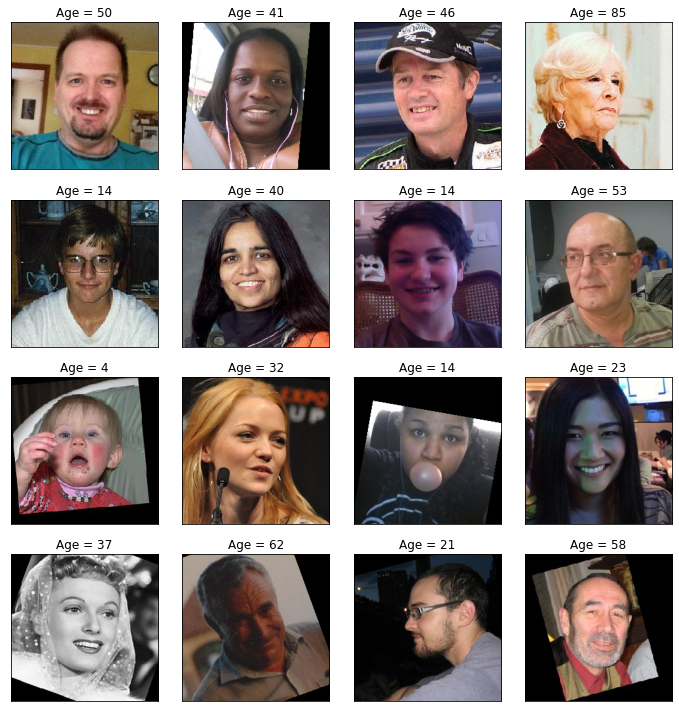

In [18]:
# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Age = {target[i]}')
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

По загруженным фотографиям можно сказать, что некоторые из них уже повернуты вокруг своей оси и уменьшены-увеличены. Значит можно использовать аугментацию с поворотом, отображением по горизонтали. 

# Обучение модели 

In [ ]:

# project face recognition ResNet (для тренажера GPU)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255,
                                       horizontal_flip=True, #vertical_flip=True,
                                       rotation_range=30)
                                       #height_shift_range=0.2,
                                       #width_shift_range=0.2)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                        directory=path+'/final_files',
                                                        x_col='file_name',
                                                        y_col='real_age',
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='raw',
                                                        subset='training',
                                                        seed=12345) 


    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    val_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
                                      
    val_datagen_flow = val_datagen.flow_from_dataframe(dataframe=labels,
                                                        directory=path+'/final_files',
                                                        x_col='file_name',
                                                        y_col='real_age',
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='raw',
                                                        subset='validation',
                                                        seed=12345) 
    return val_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 


Это последняя версия кода, отправленного на проверку в тренажер.

Здесь следующие параметры:

- `lr=0.0001`
- `epochs=10`
-  Аугментация - повороты до 30 градусов, горизонтальный флип: `horizontal_flip=True, rotation_range=30`

Результат целевой метрики $МАЕ= 6.8127$.

Ниже вывод тренажера:

    Found 5694 validated image filenames.
    Found 1897 validated image filenames.

    Train for 178 steps, validate for 60 steps
    Epoch 1/10
    2023-04-17 19:10:01.760982: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
    2023-04-17 19:10:02.182879: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
    178/178 - 102s - loss: 243.1544 - mae: 11.1692 - val_loss: 829.6845 - val_mae: 23.9004
    Epoch 2/10
    178/178 - 95s - loss: 98.4907 - mae: 7.4718 - val_loss: 601.8232 - val_mae: 19.3138
    Epoch 3/10
    178/178 - 95s - loss: 75.5548 - mae: 6.6048 - val_loss: 574.5090 - val_mae: 19.1116
    Epoch 4/10
    178/178 - 94s - loss: 61.8549 - mae: 5.9534 - val_loss: 101.1994 - val_mae: 7.6366
    Epoch 5/10
    178/178 - 94s - loss: 52.5751 - mae: 5.5448 - val_loss: 93.5552 - val_mae: 7.1735
    Epoch 6/10
    178/178 - 95s - loss: 45.1905 - mae: 5.1272 - val_loss: 106.6521 - val_mae: 7.9871
    Epoch 7/10
    178/178 - 94s - loss: 39.6016 - mae: 4.8021 - val_loss: 104.8587 - val_mae: 7.9972
    Epoch 8/10
    178/178 - 94s - loss: 34.6527 - mae: 4.5278 - val_loss: 85.2792 - val_mae: 7.1110
    Epoch 9/10
    178/178 - 98s - loss: 31.9276 - mae: 4.3420 - val_loss: 114.4891 - val_mae: 8.3248
    Epoch 10/10
    178/178 - 97s - loss: 29.2968 - mae: 4.1534 - val_loss: 83.0033 - val_mae: 6.8127
    WARNING:tensorflow:sample_weight modes were coerced from
      ...
        to  
      ['...']
    60/60 - 11s - loss: 83.0033 - mae: 6.8127
    Test MAE: 6.8127
    


До этого была так же одна версия, принятая тернажером, с метрикой $MAE = 7.4$. У той модели была другая аугментация, я выписала себе: 
- `lr=0.0001`
- `epochs=10`
- Аугментация - горизонтальный и вертикальный флип:`horizontal_flip=True, vertical_flip=True`


## Анализ обученной модели

Для решения задачи определения возраста клиентов по фотографии:

- Использован размеченный датасет с 7591 картинкой. 
- Данные разделены на обучающую и тестовую выборку в соотношении 75:25.
- Картинки загружены с помощью ImageDataGenerator.
- Для обучения использовалась сверточная сеть ResNet50:
    - ResNet50 вся обучалась на наших данных;
    - данные были загружены с размером батча `batch_size=32`;
    - т.к. стояла задача регрессии, на посленем слое был один нейрон с активацией `relu`;
    - использовался алгоритм обучения нейронной сети - Adam с `learning_rate=0.0001`;
    - функция потерь была взята - Mean Squared Error;
    - целевая метрика - Mean Absolute Error (МАЕ);
    - сеть обучалась на 10 эпохах;
    - наилучшие методы аугментации в данной задаче - повороты до 30 градусов, горизонтальный флип: `horizontal_flip=True, rotation_range=30`.
    - результат - `получить MAE модели не больше 8` - достигнут, $МАЕ= 6.8127$.
    
    
- На двух примерах можно видеть, что результат достигается уже 4-5 эпохе, метрика на тесте становится меньше 8, но потом снова начинает расти - возможно, происходит переобучение. Ведь на обучающей выборке метрика все время только уменьшалась.
    
    Однако в конце метрика на тестовой снова немного уменьшилась. Возможно использование меньшего количества эпох (5-7) для ускорения работы алгоритма без существенной потери качества.